In [23]:
import torch as t
import torch.nn.functional as F
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

from PIL import Image
from tqdm import tqdm

import os
from os import path, getcwd, listdir, mkdir
import torch as t

In [2]:
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "Helvetica"
mpl.rcParams["font.size"] = 12
mpl.rcParams["text.latex.preamble"] = "\\usepackage{amssymb} \n \\usepackage{color} \n \\usepackage{amsmath}"

In [3]:
def remove_ticklines(ax):
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)

In [4]:
def periodic_padding(image: t.Tensor, padding=1):
    """
    Create a periodic padding (wrap) around an image stack, to emulate periodic boundary conditions
    Adapted from https://github.com/tensorflow/tensorflow/issues/956

    If the image is 3-dimensional (like an image batch), padding occurs along the last two axes
    """
    if len(image.shape) == 2:
        upper_pad = image[-padding:, :]
        lower_pad = image[:padding, :]

        partial_image = t.cat([upper_pad, image, lower_pad], dim=0)

        left_pad = partial_image[:, -padding:]
        right_pad = partial_image[:, :padding]

        padded_image = t.cat([left_pad, partial_image, right_pad], dim=1)

    elif len(image.shape) == 3:
        upper_pad = image[:, -padding:, :]
        lower_pad = image[:, :padding, :]

        partial_image = t.cat([upper_pad, image, lower_pad], dim=1)

        left_pad = partial_image[:, :, -padding:]
        right_pad = partial_image[:, :, :padding]

        padded_image = t.cat([left_pad, partial_image, right_pad], axis=2)

    else:
        assert True, "Input data shape not understood."

    return padded_image

In [5]:
def unfold_conv(batch: t.Tensor) -> t.Tensor:
    unfold_transform = t.nn.Unfold(kernel_size=3)
    # provide a periodic torus padding to the grid
    padded_batch = periodic_padding(batch)
    # we need to add a channel dimension because unfold expects vectors of shape (N,C,H,W)
    padded_batch = padded_batch.unsqueeze(1)
    # apply the unfolding operator on the padded grid, this provides all convolution blocks
    unfolded_batch = unfold_transform(padded_batch)
    # turn each convolution block into a row
    batch_reshaped = unfolded_batch.permute(0, 2, 1)
    return batch_reshaped

In [6]:
def bg_contacts(conv_mat:t.Tensor) -> t.Tensor:
    num_convs = conv_mat.shape[1]
    return t.sum((1 - conv_mat) * conv_mat[:,:,4].T.expand(num_convs, 9))

In [7]:
def grid2gsc(grid, scale_min, scale_max, scale_mean, scale_std):
    mean_sampler = t.distributions.Normal(scale_mean, scale_std)
    reconstruction = t.zeros_like(grid)
    reconstruction += grid * mean_sampler.sample(reconstruction.shape)
    reconstruction = reconstruction.clamp(0,1)
    return reconstruction

In [8]:
def reconstruction_loss(ref_pic, rec_pic):
    return t.log(t.sum((ref_pic - rec_pic)**2))

In [9]:
def loss_fn(grid, ref_pic, lambda_bg=0.05, lambda_rec=1, lambda_reg=0.01):
    rec_pic = grid2gsc(grid, t.min(ref_pic), t.max(ref_pic), t.mean(ref_pic), t.std(ref_pic))
    conv_mat = unfold_conv(grid)
    return bg_contacts(conv_mat)*lambda_bg + reconstruction_loss(ref_pic, rec_pic)*lambda_rec + t.sum(grid)*lambda_reg

In [10]:
nuclei_path = path.join(getcwd(), "data", "nuclei")
nat_img_path = path.join(getcwd(), "data", "nat_img")

# Cell imaging 1

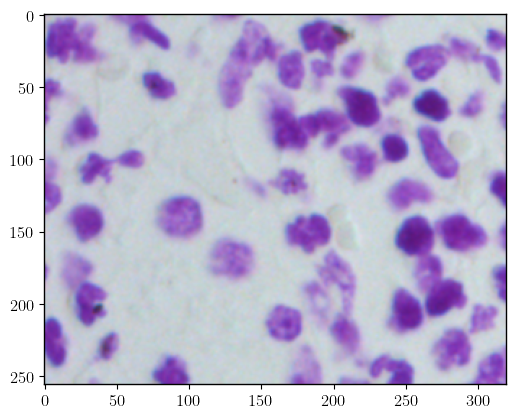

In [25]:
image_path = path.join(nuclei_path, "cells1.png")
res_path = path.join(getcwd(), "results", "cells1")
img = Image.open(image_path)
plt.imshow(img)

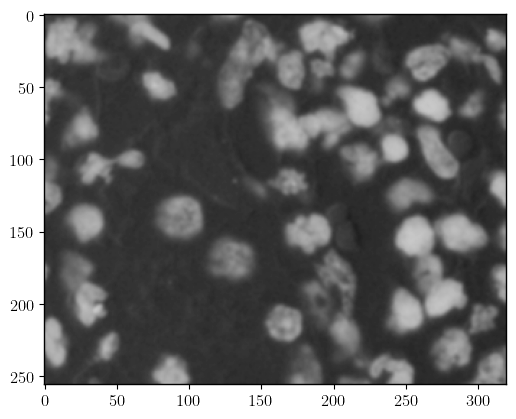

In [32]:
img_gsc = img.convert("L")
test_img = np.asarray(img_gsc)/255
grid = t.zeros_like(t.tensor(test_img))
grid = grid.unsqueeze(0)
ref = 1 - t.from_numpy(test_img)
plt.imshow(ref, cmap=plt.cm.gray, vmin=0, vmax=1)
np.save(path.join(res_path, "gsc.npy"), ref.cpu().numpy())
ref = ref.unsqueeze(0)
max_intensity = t.max(ref)
min_intensity = t.min(ref)
mean_intensity = t.mean(ref)
std_intensity = t.std(ref)

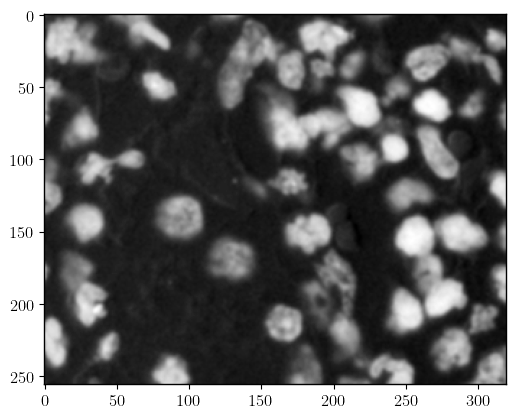

In [37]:
centering = transforms.Normalize(mean_intensity, std_intensity)
ref_centered = centering(ref)
np.save(path.join(res_path, "centered_normed.npy"), ref_centered.cpu().numpy())
plt.imshow(ref_centered[0], cmap=plt.cm.gray)

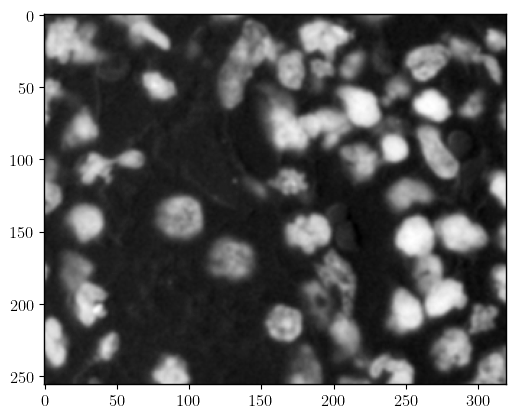

In [38]:
center2 = (ref_centered - t.min(ref_centered)) / (t.max(ref_centered) - (t.min(ref_centered))) 
np.save(path.join(res_path, "centered_normed.npy"), center2.cpu().numpy())
plt.imshow(center2[0], cmap=plt.cm.gray, vmin=0, vmax=1)

In [39]:
center2 = (ref_centered - t.min(ref_centered)) / (t.max(ref_centered) - (t.min(ref_centered)))
start_state = center2.detach().clone()

In [43]:
center2.requires_grad_()
for i in tqdm(range(2_000)):
    loss = loss_fn(center2, ref_centered)
    grads = t.autograd.grad(loss, center2)[0]
    center2 = t.clamp(center2 - 0.001 * grads, min=0, max=1)
    if i % 50 == 0:
        with t.no_grad():
            test_rec = grid2gsc(center2, t.min(ref_centered), t.max(ref_centered), t.mean(ref_centered), t.std(ref_centered))
            np.save(path.join(res_path, f"rec_{i}.npy"), test_rec.cpu().numpy())
            np.save(path.join(res_path, f"grid_{i}.npy"), center2.detach().cpu().numpy())

100%|██████████| 2000/2000 [04:33<00:00,  7.32it/s]


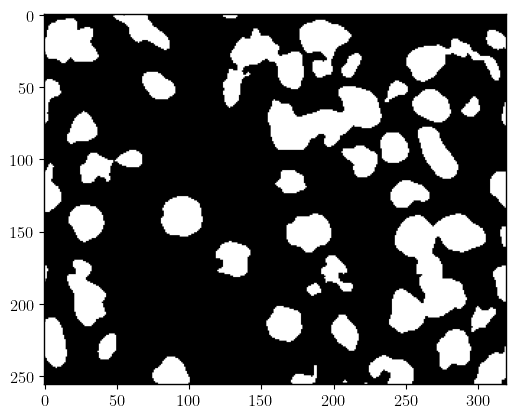

In [46]:
thres_img = center2.detach().clone()
thres_img[center2 > 0] = 1
plt.imshow(thres_img.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)

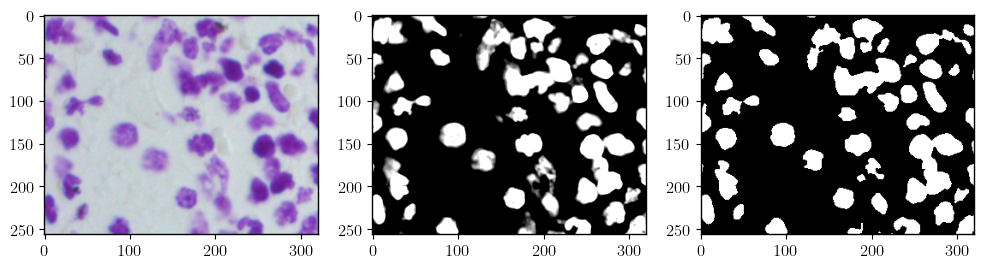

In [47]:
fig, axs = plt.subplots(1,3, figsize=(12,10))
axs[0].imshow(img)
axs[1].imshow(ref_centered.squeeze(), cmap=plt.cm.gray, vmin=0, vmax=1)
axs[2].imshow(thres_img.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)

# Cell imaging 2

In [ ]:
image_path = path.join(nuclei_path, "cells2.png")
res_path = path.join(getcwd(), "results", "cells2")
img = Image.open(image_path)
plt.imshow(img)